In [39]:
import tensorflow as tf
import os
import random
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [18]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
100% 1.17G/1.17G [00:52<00:00, 31.4MB/s]
100% 1.17G/1.17G [00:52<00:00, 24.0MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/labeled-chest-xray-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [9]:
train_dir="/content/chest_xray/train"
val_dir="/content/chest_xray/test"

In [10]:
def remove_images(folder_path, num_images_to_remove):
    all_files = os.listdir(folder_path)

    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]


    if len(image_files) < num_images_to_remove:
        return

    images_to_remove = random.sample(image_files, num_images_to_remove)

    for image in images_to_remove:
        image_path = os.path.join(folder_path, image)
        try:
            os.remove(image_path)
        except Exception as e:
          pass

folder_path = '/content/chest_xray/train/PNEUMONIA'

num_images_to_remove = 2000

remove_images(folder_path, num_images_to_remove)


In [11]:
def remove_images(folder_path, num_images_to_remove):
    all_files = os.listdir(folder_path)

    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]


    if len(image_files) < num_images_to_remove:
        return

    images_to_remove = random.sample(image_files, num_images_to_remove)

    for image in images_to_remove:
        image_path = os.path.join(folder_path, image)
        try:
            os.remove(image_path)
        except Exception as e:
          pass

folder_path = '/content/chest_xray/test/PNEUMONIA'

num_images_to_remove = 110

remove_images(folder_path, num_images_to_remove)


In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(256,256)
)

Found 3232 files belonging to 2 classes.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    image_size=(256,256)
)

Found 514 files belonging to 2 classes.


In [14]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


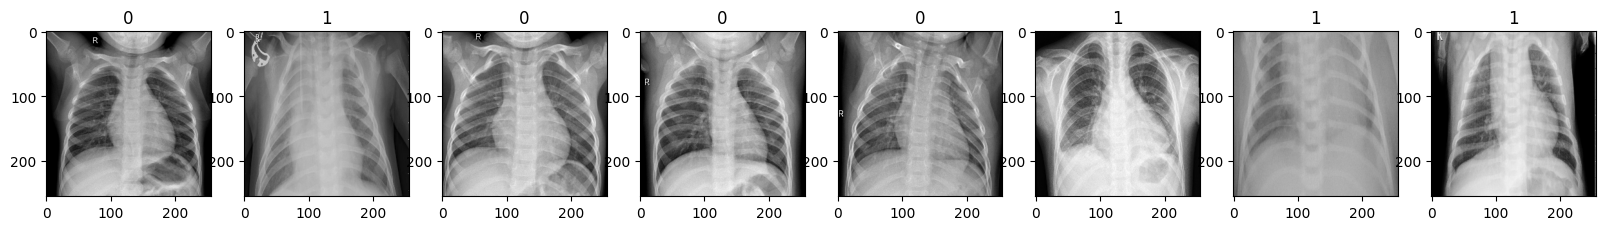

In [15]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=8 ,figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(25, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(20, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [49]:
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

In [51]:
model_filepath = "/content/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [52]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                 

In [53]:
hist = model.fit(train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping,checkpoint,lr_callback]
)

Epoch 1/25
101/101 [==============================] - ETA: 0s - loss: 0.7250 - accuracy: 0.5786
Epoch 1: val_accuracy improved from -inf to 0.54475, saving model to /content/model-01-0.5447.hdf5
101/101 [==============================] - 146s 1s/step - loss: 0.7250 - accuracy: 0.5786 - val_loss: 0.7080 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 2/25
101/101 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.5975
Epoch 2: val_accuracy improved from 0.54475 to 0.60506, saving model to /content/model-02-0.6051.hdf5
101/101 [==============================] - 147s 1s/step - loss: 0.6751 - accuracy: 0.5975 - val_loss: 0.6236 - val_accuracy: 0.6051 - lr: 0.0010
Epoch 3/25
101/101 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7113
Epoch 3: val_accuracy improved from 0.60506 to 0.80739, saving model to /content/model-03-0.8074.hdf5
101/101 [==============================] - 149s 1s/step - loss: 0.5568 - accuracy: 0.7113 - val_loss: 0.4746 - val_accu

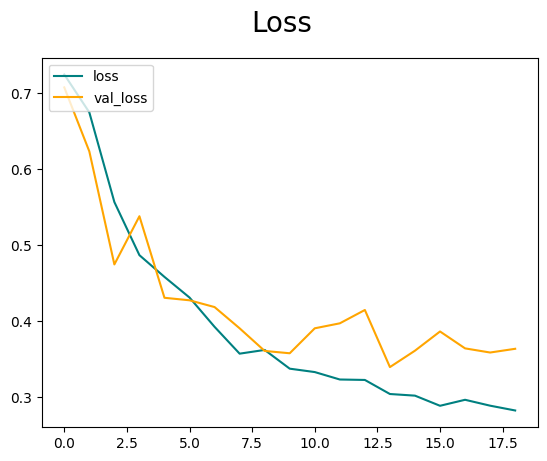

In [54]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

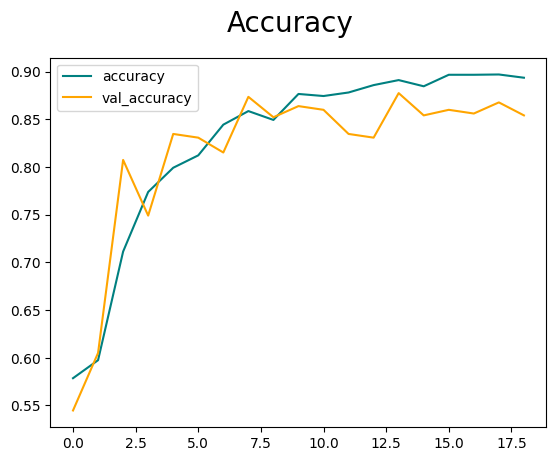

In [55]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [40]:
pre = precision()
re = recall()
acc = accuracy()
f1 = F1Score()

TypeError: 'numpy.float64' object is not callable

In [62]:
new_model = tf.keras.models.load_model('/content/model-14-0.8949.hdf5')

In [72]:
for batch in val_ds.as_numpy_iterator():
    X, y = batch
    ypre = new_model.predict(X)
    pre.update_state(y, ypre)
    re.update_state(y, ypre)
    acc.update_state(y, ypre)
    f1.update_state(y, ypre)

1/1 [==============================] - 0s 43ms/step


In [65]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.91240877, shape=(), dtype=float32) tf.Tensor(0.89285713, shape=(), dtype=float32) tf.Tensor(0.8949416, shape=(), dtype=float32)


In [19]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(256,256,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [22]:
model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [25]:
history = model.fit(
    train_ds,
    epochs=12,
    validation_data=val_ds
)

Epoch 1/12
101/101 [==============================] - 196s 2s/step - loss: 0.2124 - accuracy: 0.9177 - val_loss: 0.4288 - val_accuracy: 0.7996
Epoch 2/12
101/101 [==============================] - 197s 2s/step - loss: 0.2026 - accuracy: 0.9205 - val_loss: 0.4568 - val_accuracy: 0.7802
Epoch 3/12
101/101 [==============================] - 218s 2s/step - loss: 0.1926 - accuracy: 0.9282 - val_loss: 0.4268 - val_accuracy: 0.7977
Epoch 4/12
101/101 [==============================] - 201s 2s/step - loss: 0.1842 - accuracy: 0.9322 - val_loss: 0.4532 - val_accuracy: 0.7918
Epoch 5/12
101/101 [==============================] - 207s 2s/step - loss: 0.1763 - accuracy: 0.9366 - val_loss: 0.4932 - val_accuracy: 0.7821
Epoch 6/12
101/101 [==============================] - 200s 2s/step - loss: 0.1722 - accuracy: 0.9378 - val_loss: 0.4196 - val_accuracy: 0.8132
Epoch 7/12
101/101 [==============================] - 202s 2s/step - loss: 0.1699 - accuracy: 0.9390 - val_loss: 0.4039 - val_accuracy: 0.8152

In [36]:
model.save('models/fine_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation accuracy after fine-tuning: {accuracy:.2f}")

17/17 [==============================] - 29s 2s/step - loss: 0.4835 - accuracy: 0.7977
Validation accuracy after fine-tuning: 0.80


In [31]:
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_fine = model.fit(
    train_ds,
    initial_epoch=history.epoch[-1],
    epochs=19,
    validation_data=val_ds
)

Epoch 12/19
101/101 [==============================] - 246s 2s/step - loss: 0.1466 - accuracy: 0.9567 - val_loss: 6.8863 - val_accuracy: 0.4883
Epoch 13/19
101/101 [==============================] - 239s 2s/step - loss: 0.0766 - accuracy: 0.9771 - val_loss: 13.7714 - val_accuracy: 0.4553
Epoch 14/19
101/101 [==============================] - 227s 2s/step - loss: 0.0214 - accuracy: 0.9923 - val_loss: 19.7331 - val_accuracy: 0.4553
Epoch 15/19
101/101 [==============================] - 240s 2s/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 1.6947 - val_accuracy: 0.7918
Epoch 16/19
101/101 [==============================] - 240s 2s/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 10.8512 - val_accuracy: 0.4630
Epoch 17/19
101/101 [==============================] - 227s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 12.0459 - val_accuracy: 0.4689
Epoch 18/19
101/101 [==============================] - 241s 2s/step - loss: 4.7599e-04 - accuracy: 1.0000 - val_loss: 9.9346 - val_a

In [32]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation accuracy after fine-tuning: {accuracy:.2f}")

17/17 [==============================] - 41s 2s/step - loss: 7.5926 - accuracy: 0.5311
Validation accuracy after fine-tuning: 0.53


In [6]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.0 MB/

In [46]:
import gradio as gr
from PIL import Image
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('/content/model-14-0.8949.hdf5')
class_names = ['NORMAL', 'PNEUMONIA']
def preprocess_image(image):
    image = image.resize((256, 256))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def predict(image):
    """Make a prediction based on the input image."""
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    predicted_class = np.argmax(prediction, axis=1)
    confidence_score = np.max(prediction)
    return f"اتوكع: {class_names[predicted_class[0]]} with confidence score: {confidence_score:.2f}"

# Create a Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Image Classification App",
    description="يرجي رفع الصورة"
)


interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://83590da78be96633f8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
